**Modulo 4 : Entrenamiento para Datos Tabulares**
* Instructor: [Juan Maniglia](https://juanmaniglia.github.io)

# Parte 4.3: Keras Regresión para Deep Neural Networks con RMSE

Los resultados de la regresión se evalúan de forma diferente a la clasificación. Considere el siguiente código que entrena una red neuronal para la regresión en el conjunto de datos **jh-simple-dataset.csv**.

In [1]:
import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Leer el dataset
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

# Generar dummies para 'job'
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generar dummies para 'area'
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Generar dummies para 'product'
df = pd.concat([df,pd.get_dummies(df['product'],prefix="product")],axis=1)
df.drop('product', axis=1, inplace=True)

# Tratar Missing values en 'income'
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Estandarizar rangos
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convertir a numpy - Clasificación
x_columns = df.columns.drop('age').drop('id')
x = df[x_columns].values
y = df['age'].values

# Dividir en train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

# Construir la red neural
model = Sequential()
model.add(Dense(25, input_dim=x.shape[1], activation='relu')) # Oculta 1
model.add(Dense(10, activation='relu')) # Oculta 2
model.add(Dense(1)) # Salida
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                        patience=5, verbose=1, mode='auto', 
                        restore_best_weights=True)
model.fit(x_train,y_train,validation_data=(x_test,y_test),
          callbacks=[monitor],verbose=2,epochs=1000)


Epoch 1/1000
47/47 - 1s - loss: 1640.9529 - val_loss: 1294.8827 - 1s/epoch - 23ms/step
Epoch 2/1000
47/47 - 0s - loss: 904.3422 - val_loss: 527.8795 - 133ms/epoch - 3ms/step
Epoch 3/1000
47/47 - 0s - loss: 356.7660 - val_loss: 272.1019 - 129ms/epoch - 3ms/step
Epoch 4/1000
47/47 - 0s - loss: 264.7375 - val_loss: 241.3680 - 128ms/epoch - 3ms/step
Epoch 5/1000
47/47 - 0s - loss: 232.3135 - val_loss: 207.8772 - 129ms/epoch - 3ms/step
Epoch 6/1000
47/47 - 0s - loss: 194.1138 - val_loss: 169.9554 - 132ms/epoch - 3ms/step
Epoch 7/1000
47/47 - 0s - loss: 154.5060 - val_loss: 133.4084 - 127ms/epoch - 3ms/step
Epoch 8/1000
47/47 - 0s - loss: 118.5248 - val_loss: 102.3987 - 129ms/epoch - 3ms/step
Epoch 9/1000
47/47 - 0s - loss: 90.2054 - val_loss: 80.6277 - 128ms/epoch - 3ms/step
Epoch 10/1000
47/47 - 0s - loss: 69.9915 - val_loss: 65.0487 - 130ms/epoch - 3ms/step
Epoch 11/1000
47/47 - 0s - loss: 56.4852 - val_loss: 54.3472 - 129ms/epoch - 3ms/step
Epoch 12/1000
47/47 - 0s - loss: 47.1323 - val_

### Mean Square Error

El error cuadrático medio es la suma de las diferencias al cuadrado entre la predicción ($\hat{y}$) y la esperada ($y$). Los valores de MSE no son de una unidad en particular. Si un valor de MSE ha disminuido para un modelo, eso es bueno. Sin embargo, más allá de esto, no hay mucho más que puedas determinar. Se desean valores bajos de MSE.

$$ {MSE} = \frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2 $$ 


In [3]:
from sklearn import metrics

# Predict
pred = model.predict(x_test)

# MSE error.  
score = metrics.mean_squared_error(pred,y_test)
print("Final score (MSE): {}".format(score))

Final score (MSE): 0.5963144368181893


### Root Mean Square Error

The root mean square (RMSE) es esencialmente la raíz cuadrada del MSE. Debido a esto, el error de RMSE está en las mismas unidades que el resultado de los datos de entrenamiento. Se desean valores bajos de RMSE.

$$ {RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2} $$

In [4]:
import numpy as np

# RMSE error.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.7722139838271445


### Gráfico de elevación


Para generar un gráfico de elevación, realice las siguientes actividades:

* Ordenar los datos por salida esperada. Trace la línea azul arriba.
* Para cada punto en el eje x, grafique el valor predicho para ese mismo punto de datos. Esta es la línea verde de arriba.
* El eje x es solo del 0 al 100 % del conjunto de datos. Lo esperado siempre comienza bajo y termina alto.
* El eje y está ordenado según los valores predichos.

Lectura de un gráfico de elevación:

* Las líneas esperadas y predichas deben estar cerca. Observe dónde está uno por encima del otro.
* La siguiente tabla es la más precisa para edades más bajas.

In [11]:
# Gráfico de Regresión.
def chart_regression(pred, y, sort=True):
    plt.figure(figsize=(15,10))
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

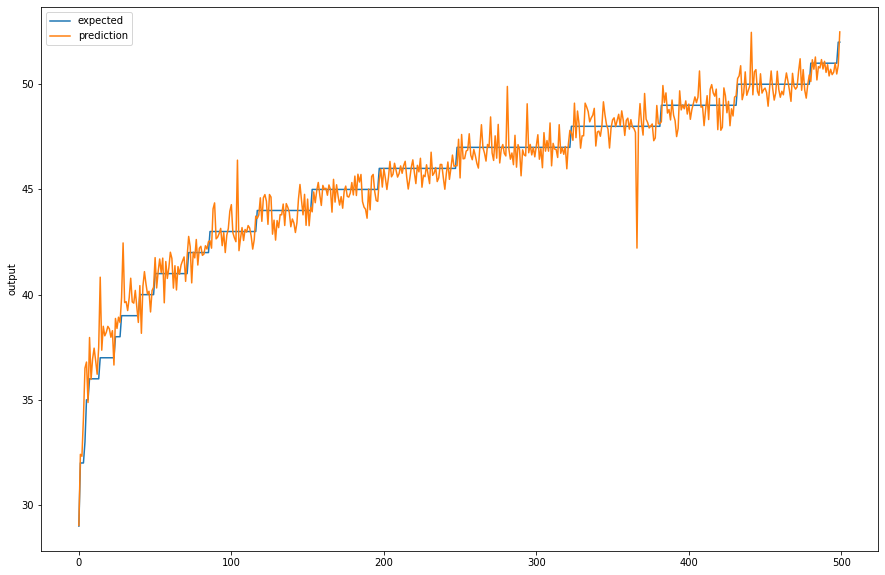

In [12]:
chart_regression(pred.flatten(),y_test)